# NER for constructing KG

In [1]:
!pip install datasets pytorch-crf

## EDA and preprocessing CoNLL04


In this experiment will be used [CoNLL04 dataset](https://huggingface.co/datasets/DFKI-SLT/conll04) which contains extracted named entities (ORG, LOC, PER, MISC), their relations (Located_In, Work_For, OrgBased_In, Live_In, Kill), and corresponding texts. The CoNLL04 dataset is a benchmark dataset for relation extraction tasks. The data is primarily based on news articles. The original dataset is governed by the Creative Commons Attribution-NonCommercial-ShareAlike 3.0 International License (CC BY-NC-SA 3.0) and can be found [here](https://cogcomp.seas.upenn.edu/page/resource_view/43)

In [45]:
from datasets import load_dataset
dataset = load_dataset("DFKI-SLT/conll04")

The dataset has already contained data for training, validation and testing. Let's convert all JSON data in DataFrame.

In [54]:
df_train = dataset["train"].to_pandas()
df_val = dataset["validation"].to_pandas()
df_test = dataset["test"].to_pandas()
df_train.head()

,entities,tokens,relations,orig_id
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210


The dataset does not contain NaNs, all columns (instead of unique id) are of object data type.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   entities   922 non-null    object
 1   tokens     922 non-null    object
 2   relations  922 non-null    object
 3   orig_id    922 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 28.9+ KB


Let's provide basic statistics

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")

In [6]:
print("Training samples:", len(df_train))
print("Test samples:", len(df_test))

Training samples: 922
Test samples: 288


#### Texts and tokens

In [7]:
df_train["texts"] = df_train["tokens"].apply(lambda x: " ".join(x))
df_test["texts"] = df_test["tokens"].apply(lambda x: " ".join(x))
df_train.head()

,entities,tokens,relations,orig_id,texts
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...


Examples of texts

In [8]:
for i in df_train.sample(frac=1).head(5)['texts']:
    print(i)

` ` The thing to remember is Florida had an education governor , Bob Graham , and he made a substantial investment in schools long before other states were even thinking about reform. ' '
( Article by Nick Rufford , Far East correspondent )
( Text ) The National Space Development Agency of Japan ( NASDA ) will soon start remodeling the domestically-made , large-scale H-2 rocket , which was successfully test-launched recently .
Democratic Gov. Gerald Baliles of Virginia , who was being replaced as chairman of the governors ' association by Republican Terry Branstad of Iowa , said , ` ` We 're impressed with the accessibility and indications of a cooperative attitude ' ' from Bush.
Surratt , a young Confederate spy who had conspired with John Wilkes Booth to abduct Lincoln in 1864 , fled after Booth shot Lincoln on April 14 , 1865 .


Plot token count distribution

Total Tokens: 26525
Average Tokens Per Row: 28.77


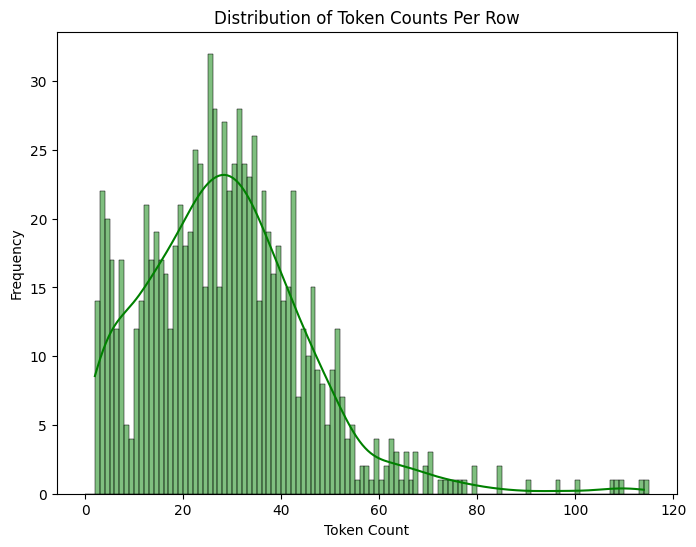

In [9]:
token_counts = [len(tokens) for tokens in df_train['tokens']]
total_tokens = sum(token_counts)
average_token_length = sum(token_counts) / len(token_counts)

print(f"Total Tokens: {total_tokens}")
print(f"Average Tokens Per Row: {average_token_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(token_counts, bins=range(0, max(token_counts) + 2), kde=True, color='green')
plt.title('Distribution of Token Counts Per Row')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

Total Characters: 143962
Average Characters Per Row: 156.14


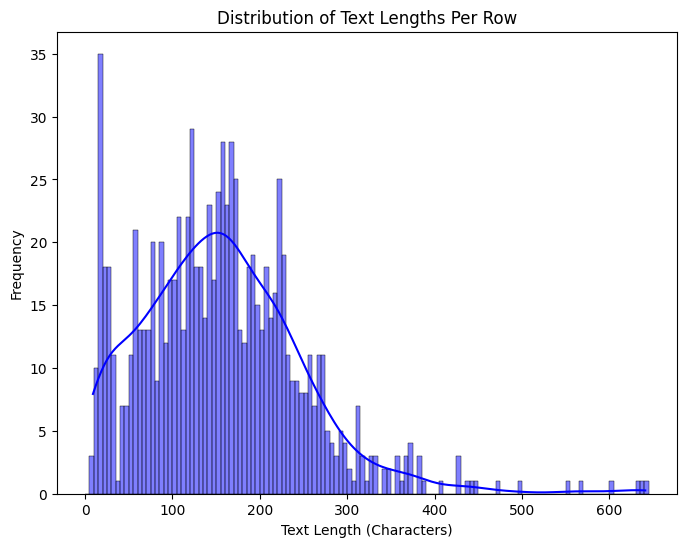

In [10]:
text_lengths = [len(text) for text in df_train['texts']]
total_text_length = sum(text_lengths)
average_text_length = sum(text_lengths) / len(text_lengths)

print(f"Total Characters: {total_text_length}")
print(f"Average Characters Per Row: {average_text_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, bins=range(0, max(text_lengths) + 5, 5), kde=True, color='blue')
plt.title('Distribution of Text Lengths Per Row')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

#### Entities

In [11]:
def create_named_entities(entities, tokens):
    named_entities = []
    for entity in entities:
        start = entity['start']
        end = entity['end']
        entity_type = entity['type']
        entity_text = ' '.join(tokens[start:end])
        entry = f"{entity_text} ({start}, {end}) : {entity_type}"
        named_entities.append(entry)
    return named_entities

In [12]:
df_train['named_entities'] = df_train.apply(lambda row: create_named_entities(row['entities'], row['tokens']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter..."
...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ..."


In [13]:
def categorize_entities(entities_list):
    categories = {'Peop': 0, 'Loc': 0, 'Org': 0, 'Other': 0}
    for entity_str in entities_list:
        parts = entity_str.split(': ')
        if len(parts) >= 2:
            entity_type = parts[1].strip()
            if entity_type in categories:
                categories[entity_type] += 1
    return categories

In [14]:
train_ent = df_train[['orig_id', 'named_entities']]
train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)
train_ent

<ipython-input-14-1b412a188198>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)


,orig_id,named_entities,entity_categories
0,3255,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...","{'Peop': 0, 'Loc': 2, 'Org': 1, 'Other': 2}"
1,95,"[150 , 000 hectares (22, 26) : Other, 370 , 50...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 3}"
2,2447,"[20 miles (19, 21) : Other, Louisiana (23, 24)...","{'Peop': 1, 'Loc': 2, 'Org': 0, 'Other': 1}"
3,5284,"[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","{'Peop': 3, 'Loc': 1, 'Org': 0, 'Other': 0}"
4,210,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...","{'Peop': 2, 'Loc': 2, 'Org': 0, 'Other': 1}"
...,...,...,...
917,5423,"[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...","{'Peop': 1, 'Loc': 1, 'Org': 1, 'Other': 1}"
918,1269,"[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 0}"
919,4136,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","{'Peop': 1, 'Loc': 2, 'Org': 1, 'Other': 0}"
920,1452,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...","{'Peop': 0, 'Loc': 1, 'Org': 1, 'Other': 0}"


In [15]:
categories = ['Peop', 'Loc', 'Org', 'Other']

encoded_ent = train_ent['entity_categories'].apply(
    lambda x: {cat: x.get(cat, 0) for cat in categories}
).apply(pd.Series)

encoded_ent = pd.concat(
    [train_ent[['orig_id']], encoded_ent],
    axis=1
)

encoded_ent

,orig_id,Peop,Loc,Org,Other
0,3255,0,2,1,2
1,95,1,0,1,3
2,2447,1,2,0,1
3,5284,3,1,0,0
4,210,2,2,0,1
...,...,...,...,...,...
917,5423,1,1,1,1
918,1269,1,0,1,0
919,4136,1,2,1,0
920,1452,0,1,1,0


Plot a bar chart

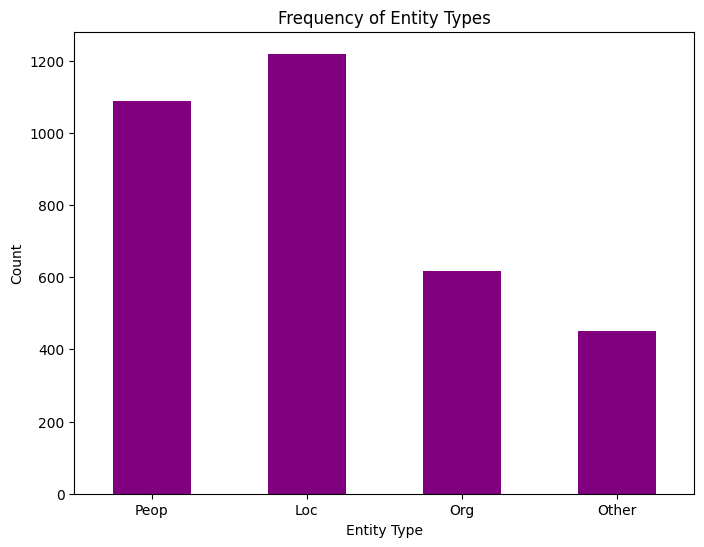

In [16]:
entity_counts = encoded_ent[['Peop', 'Loc', 'Org', 'Other']].sum()

plt.figure(figsize=(8, 6))
entity_counts.plot(kind='bar', color=['purple'])
plt.title('Frequency of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### Triplets

In [17]:
def create_triplets(relations, named_entities):
    triplets = []
    for relation in relations:
        head_idx = relation['head']
        tail_idx = relation['tail']
        rel_type = relation['type']

        head_entity_str = named_entities[head_idx]
        tail_entity_str = named_entities[tail_idx]

        head_text = head_entity_str.split(' (', 1)[0].strip()
        tail_text = tail_entity_str.split(' (', 1)[0].strip()

        triplet = f"{head_text}|{rel_type}|{tail_text}"
        triplets.append(triplet)
    return triplets

In [18]:
df_train['triplets'] = df_train.apply(lambda row: create_triplets(row['relations'], row['named_entities']), axis=1)
df_train['triplet_count'] = df_train['triplets'].apply(len)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets,triplet_count
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Radio Reloj Network|OrgBased_In|Havana],1
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Bruno Pusterla|Work_For|Italian Agricultural ...,1
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Morgan City|Located_In|Louisiana],1
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Annie Oakley|Live_In|Willowdell , Darke Count...",3
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Livingston|Located_In|Texas],1
...,...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Lawrence Welk|Live_In|North Dakota],1
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Robert C. Anderson|Work_For|GE],1
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...",[Ejup Ganic|Live_In|Federation of Bosnia-Herze...,2
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Eaglebrook East|OrgBased_In|Middletown],1


Plot the distribution of triplets

Total number of triplets in the dataset: 1283


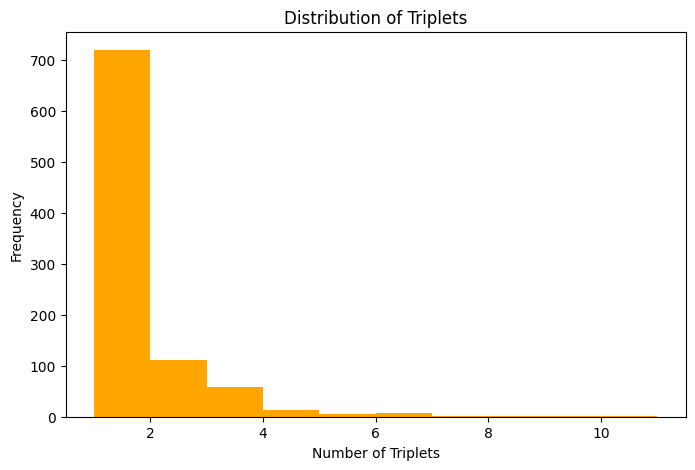

In [19]:
total_triplets = df_train['triplet_count'].sum()
print(f"Total number of triplets in the dataset: {total_triplets}")

plt.figure(figsize=(8, 5))
plt.hist(df_train['triplet_count'], bins=range(1, 12), color='orange')
plt.title("Distribution of Triplets")
plt.xlabel("Number of Triplets")
plt.ylabel("Frequency")
plt.show()

## LLM approach for NER task: BERT

The proposed model leverages the BERT as a contextual feature extractor (contextual embeddings state features) and combines it with a Conditional Random Fields (CRF) layer for performing NER task. Transition features represents as IOB2-tagged tokens (BIO-tagging).

The arhitecture of the model was given from [here. [Harnoune A. 2021]](https://www.sciencedirect.com/science/article/pii/S2666990021000410?ref=pdf_download&fr=RR-2&rr=936f9a883908ec56#page=5.30)

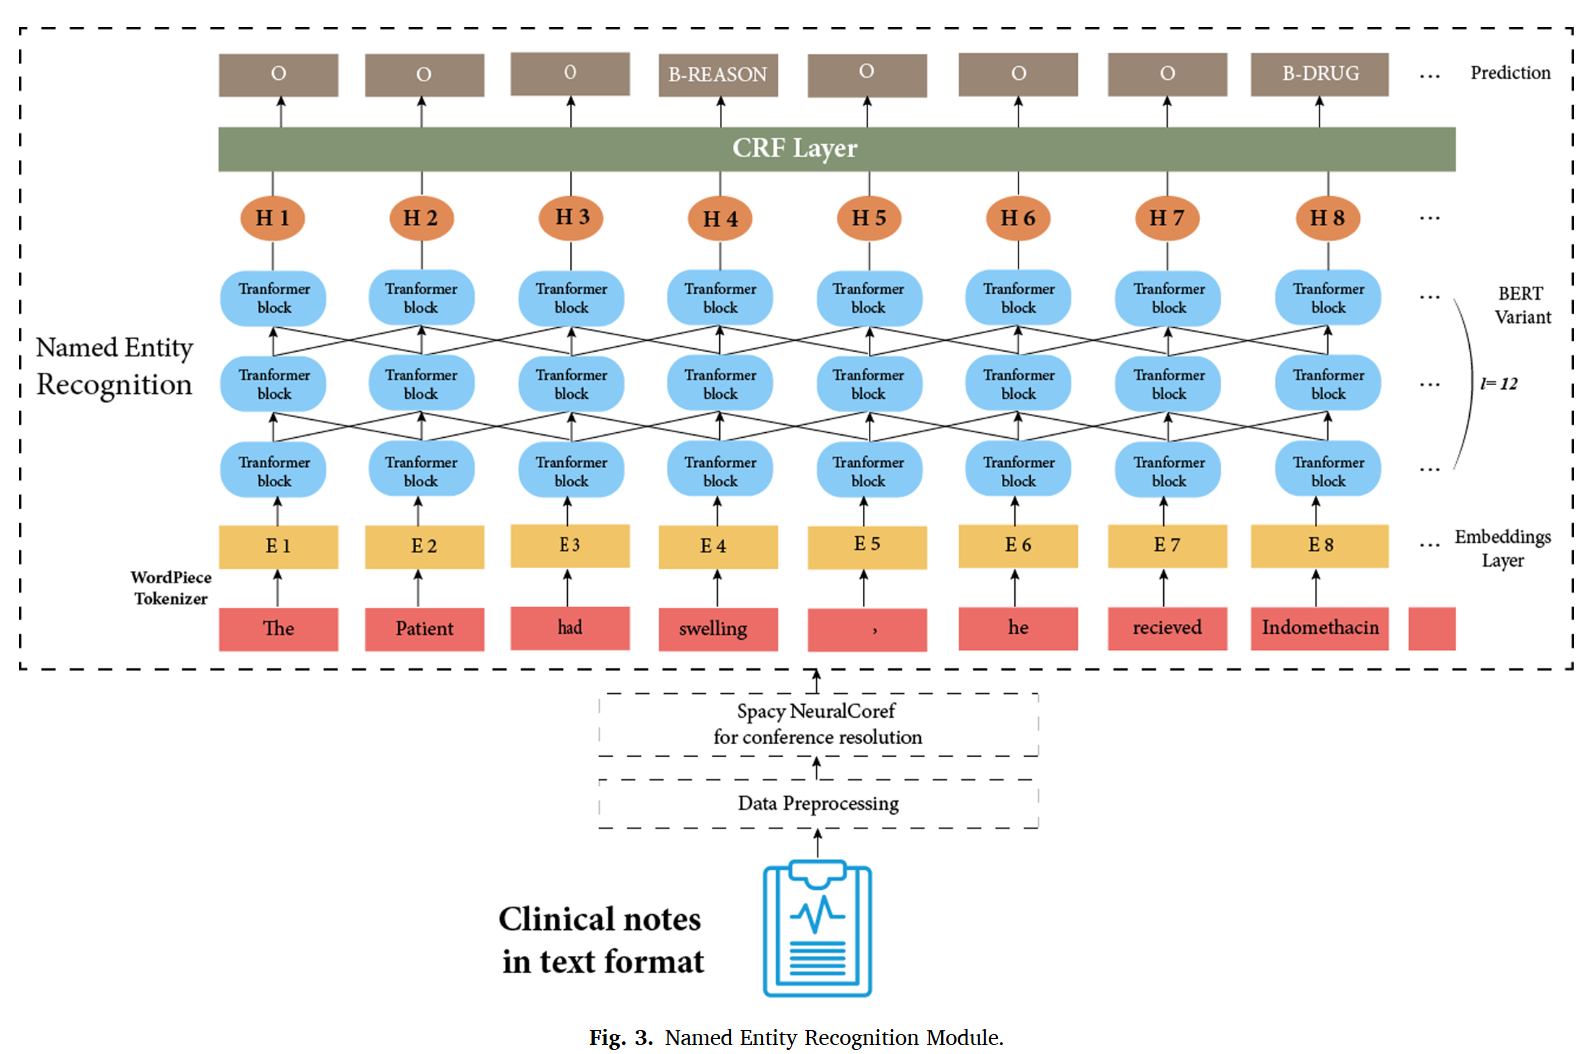


The configuration of the architecture:
* 12 stacked encoders (each layer contains Self-Attention и Feed-Forward Network)
* hidden size = 768 (the number of features of the
hidden state -- standart)
* 12 heads in the MultiHead attention layers
* input size = 128 (max len of seq per step was reduced for optimization)
* batch size = 17 (num of examples per step was reduced for optimization
* num of epochs = 10
- a **CRF layer** which allows to link the result obtained with the
appropriate class of the named entity

### Preprocessing data

In [20]:
import numpy as np
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

In [55]:
def generate_bio_tags(tokens, entities):
    bio_tags = ['O'] * len(tokens)
    for entity in entities:
        start = entity['start']
        end = entity['end']
        typ = entity['type']
        if start < len(bio_tags):
            bio_tags[start] = f'B-{typ}'
        for i in range(start + 1, end):
            if i < len(bio_tags):
                bio_tags[i] = f'I-{typ}'
    return bio_tags

In [58]:
df_train['bio_tags'] = df_train.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_val['bio_tags'] = df_val.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)
df_test['bio_tags'] = df_test.apply(lambda row: generate_bio_tags(row['tokens'], row['entities']), axis=1)

df_train = df_train[['tokens', 'bio_tags']]
df_val = df_val[['tokens', 'bio_tags']]

df_test = df_test[['tokens', 'bio_tags']]
df_test = df_test[['tokens', 'bio_tags']]

df_test

,tokens,bio_tags
0,"[An, art, exhibit, at, the, Hakawati, Theatre,...","[O, O, O, O, O, B-Org, I-Org, O, B-Other, O, B..."
1,"[PERUGIA, ,, Italy, (, AP, )]","[B-Loc, O, B-Loc, O, B-Org, O]"
2,"[Reagan, sounded, positive, notes, reminiscent...","[B-Peop, O, O, O, O, O, O, O, O, O, O, O, O, O..."
3,"[There, was, no, mention, of, the, `, `, iron,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[Nor, did, he, argue, ,, as, he, did, in, a, s...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-Org,..."
...,...,...
283,"[Photo, ,, COLOR, ,, The, father, of, our, 34t...","[B-Other, O, B-Other, O, O, O, O, O, O, O, O, ..."
284,"[Bette, Davis, was, born, Ruth, Elizabeth, Dav...","[B-Peop, I-Peop, O, O, B-Peop, I-Peop, I-Peop,..."
285,"[On, Oct., 18, ,, 1921, ,, Jesse, Alexander, H...","[O, B-Other, O, O, O, O, B-Peop, I-Peop, I-Peo..."
286,"[The, House, voted, Thursday, to, withdraw, a,...","[O, B-Org, O, B-Other, O, O, O, O, O, O, O, B-..."


In [62]:
# numpy array to list
df_train['tokens'] = df_train['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df_val['tokens'] = df_val['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
df_test['tokens'] = df_test['tokens'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [25]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

label2id = {"O": 0, "B-Peop": 1, "I-Peop": 2, "B-Org": 3, "I-Org": 4, "B-Loc": 5, "I-Loc": 6, "B-Other": 7, "I-Other": 8,}
id2label = {v: k for k, v in label2id.items()}

In [26]:
def tokenize_and_align_labels(tokens, labels, tokenizer, label2id, max_length=128):
    tokenized_inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    word_ids = tokenized_inputs.word_ids()  # list of ID of tokens for each subtoken
    previous_word_idx = None
    aligned_labels = []
    for word_id in word_ids:
        if word_id is None:  # CLS, SEP, or PAD
            aligned_labels.append(0)  # mask will ignore it
        else:
            original_label = labels[word_id]
            if word_id != previous_word_idx:
                aligned_labels.append(label2id[original_label])
                previous_word_idx = word_id
            else:
                if original_label.startswith("B-") or original_label.startswith("I-"):
                    entity_type = original_label[2:]
                    i_label = f"I-{entity_type}"
                    aligned_labels.append(label2id[i_label])
                else:
                    aligned_labels.append(label2id["O"])
    tokenized_inputs["labels"] = torch.tensor(aligned_labels)
    return tokenized_inputs

In [27]:
class NERDataset(Dataset):
    def __init__(self, df, tokenizer, label2id, max_length=128):
        self.df = df
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        tokens = self.df.iloc[idx]["tokens"]
        labels = self.df.iloc[idx]["bio_tags"]
        tokenized_data = tokenize_and_align_labels(
            tokens,
            labels,
            self.tokenizer,
            self.label2id,
            self.max_length
        )
        return {
            "input_ids": tokenized_data["input_ids"].squeeze(0),
            "attention_mask": tokenized_data["attention_mask"].squeeze(0),
            "labels": tokenized_data["labels"]
        }

### Training

In [28]:
import torch
import torch.nn as nn
from torchcrf import CRF
from torch.optim import AdamW
from transformers import AutoModel

from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [29]:
class BertCrf(nn.Module):
    def __init__(self, num_labels, bert_name, dropout=0.2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_name)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_tags=num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        emissions = self.fc(self.dropout(sequence_output))

        if labels is not None:
            log_likelihood = self.crf(emissions, labels, mask=attention_mask.bool())
            return -log_likelihood
        else:
            mask = attention_mask.bool()
            return self.crf.decode(emissions, mask=mask)

    def save_to(self, path):
        torch.save(self.state_dict(), path)

    def load_from(self, path):
        self.load_state_dict(torch.load(path))

In [30]:
def compute_f1(preds, labels):
    preds_flat = [tag for seq in preds for tag in seq]
    labels_flat = [
        label for seq in labels for label in seq if label != -100  # Ignore -100
    ]

    return f1_score(labels_flat, preds_flat, average='micro')

In [31]:
def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Calculate loss
            loss = model(input_ids, attention_mask, labels)
            total_loss += loss.item()

            # Get predictions
            predictions = model(input_ids, attention_mask)

            all_preds.extend(predictions)

            # Flatten labels while ignoring -100
            active_labels = [
                [label for label, mask in zip(seq_labels, seq_mask) if mask]
                for seq_labels, seq_mask in zip(labels.cpu().numpy(), attention_mask.cpu().numpy())
            ]
            all_labels.extend(active_labels)

    avg_val_loss = total_loss / len(val_loader)
    return avg_val_loss, all_preds, all_labels

In [32]:
def visualize_metrics(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue")
    plt.plot(epochs, val_losses, label="Val Loss", color="orange")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertCrf(num_labels=len(label2id), bert_name="bert-base-uncased").to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


def train_model(model, train_loader, val_loader, epochs=10, patience=3):
    model.train()

    train_losses, val_losses, val_f1_scores = [], [], []

    # Early stopping
    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            loss = model(input_ids, attention_mask, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #  Validation
        val_loss, val_preds, val_labels = evaluate_model(model, val_loader)
        val_f1 = compute_f1(val_preds, val_labels)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val micro-F1: {val_f1:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            model.save_to('model.pt')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        # updating learning rate
        scheduler.step()

    visualize_metrics(train_losses, val_losses, val_f1_scores)

In [34]:
train_dataset = NERDataset(df_train, tokenizer, label2id)
train_loader = DataLoader(train_dataset, batch_size=17, shuffle=True)

val_dataset = NERDataset(df_val, tokenizer, label2id)
val_loader = DataLoader(val_dataset, batch_size=17, shuffle=False)

train_model(model, train_loader, val_loader, epochs=10, patience=4)

### Evaluating

In [63]:
test_dataset = NERDataset(df_test, tokenizer, label2id)
test_loader = DataLoader(test_dataset, batch_size=17, shuffle=False)

In [68]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
model = BertCrf(num_labels=len(label2id), bert_name="bert-base-uncased")
model.load_from('model.pt')
model.to(device)
model.eval()

test_loss, test_preds, test_labels = evaluate_model(model, test_loader)

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

In [69]:
true_labels = []
pred_labels = []
for labels_seq, preds_seq in zip(test_labels, test_preds):
    for true_tag, pred_tag in zip(labels_seq, preds_seq):
        if true_tag != -100:
            true_labels.append(id2label[true_tag])
            pred_labels.append(id2label[pred_tag])

print(classification_report(
    true_labels,
    pred_labels,
    digits=4,
    target_names=label2id.keys()
))

              precision    recall  f1-score   support

           O     0.7926    0.9485    0.8635       427
      B-Peop     0.8000    0.6263    0.7025       198
      I-Peop     0.7907    0.5113    0.6210       133
       B-Org     0.9162    0.9533    0.9344       321
       I-Org     0.8093    0.7992    0.8042       478
       B-Loc     0.7775    0.7830    0.7803       424
       I-Loc     0.7053    0.7374    0.7210       198
     B-Other     0.9643    0.9474    0.9558       742
     I-Other     0.9723    0.9723    0.9723      7516

    accuracy                         0.9365     10437
   macro avg     0.8365    0.8087    0.8172     10437
weighted avg     0.9366    0.9365    0.9357     10437



In [70]:
micro_f1 = f1_score(true_labels, pred_labels, average='micro')

print(f"micro-F1: {micro_f1:.4f}")

micro-F1: 0.9365


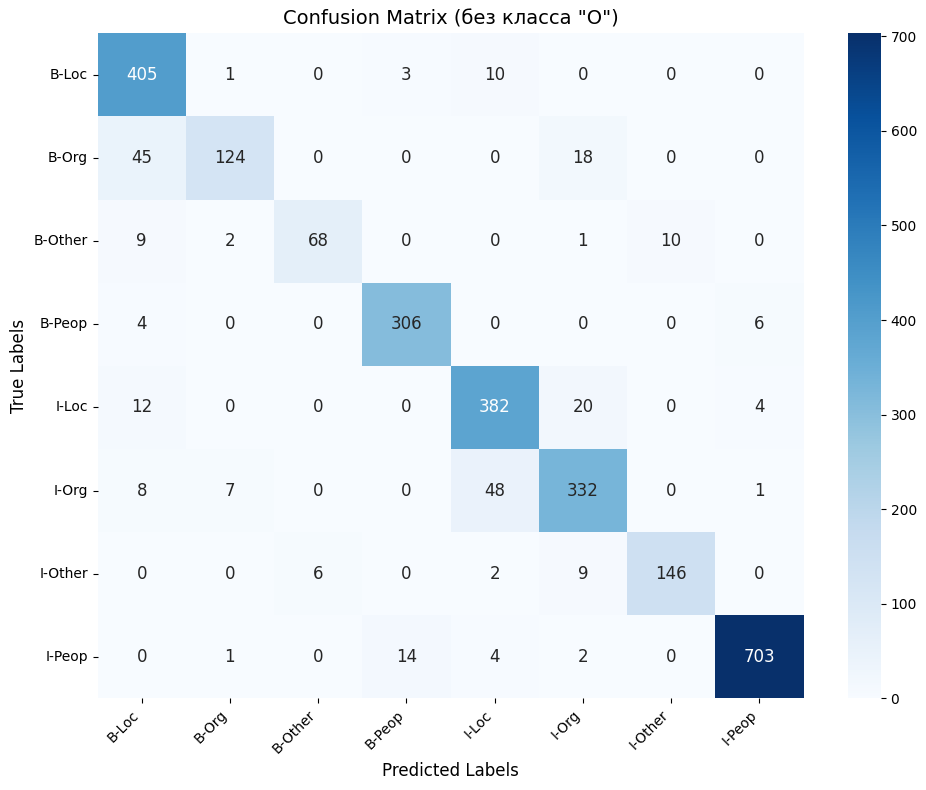

In [74]:
filtered_true = []
filtered_pred = []
for labels_seq, preds_seq in zip(test_labels, test_preds):
    for true_tag_id, pred_tag_id in zip(labels_seq, preds_seq):
        if true_tag_id == -100:
            continue
        true_tag = id2label[true_tag_id]
        pred_tag = id2label[pred_tag_id]
        if true_tag != 'O':
            filtered_true.append(true_tag)
            filtered_pred.append(pred_tag)

labels = sorted(list(set(filtered_true + filtered_pred) - {'O'}))

cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 12})
plt.title('Confusion Matrix (без класса "O")', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()